## Here 1

In [ ]:
sample = "[16.22, 84.86, 36.76, 52.43, 69.19, 45.95, 108.11, 50.27, 118.92, 60.0, 134.05, 76.22, 132.97, 104.32, 145.95, 128.11, 151.35, 143.24, 143.78, 164.86, 139.46, 174.59, 151.35, 191.89, 189.19, 223.24, 230.27, 265.41, 235.68, 268.65, 238.92, 282.7, 232.43, 297.84, 223.78, 302.16, 183.78, 290.27, 158.92, 271.89, 105.95, 251.35, 122.16, 272.97, 137.3, 287.03, 149.19, 312.97, 162.16, 338.92, 169.73, 349.73, 174.05, 361.62, 161.08, 396.22, 149.19, 423.24, 139.46, 437.3, 125.41, 448.11, 113.51, 453.51, 104.86, 454.59, 98.38, 444.86, 78.92, 426.49, 55.14, 402.7, 40.0, 387.57, 21.62, 368.11, 1.08, 348.65, 0.0, 136.76, 0.0, 123.78]"

In [ ]:
sample = sample.replace('[', '').replace(']', '').split(', ')

In [ ]:
sample = list(map(lambda i: float(i), sample))

In [ ]:
sample = [round(sample[i]/640, 3) if i%2!=0 else round(sample[i]/480, 3) for i in range(len(sample))]

In [ ]:
sample = str(sample)

In [ ]:
from transformers import AutoModelForVision2Seq, AutoTokenizer, AutoProcessor
import torch

model_name = "HuggingFaceTB/SmolVLM-256M-Instruct"
model = AutoModelForVision2Seq.from_pretrained(model_name, torch_dtype=torch.float16).to("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)

In [ ]:
import numpy as np

# Generate the float numbers from 0.00 to 1.00 with a step of 0.01
float_numbers = np.arange(0.00, 1.001, 0.001)
precision = 0.001
# Convert the float numbers to strings with two decimal places
new_tokens = [f"{num:.{len(str(precision).split('.')[-1])}f}" for num in float_numbers]

# Assuming 'processor' is an object that has a 'tokenizer' attribute
# and that 'tokenizer' has an 'add_tokens' method (common in libraries like Hugging Face Transformers)
processor.tokenizer.add_tokens(new_tokens)
processor.tokenizer.add_tokens([', '])

In [ ]:
sample

In [ ]:
processor.tokenizer.encode('[')

In [ ]:
len(processor.tokenizer.encode(sample))

In [ ]:
processor.tokenizer.encode('[0.034, 0.133, 0.077]')

In [ ]:
model.lm_head

In [ ]:
model.resize_token_embeddings(len(processor.tokenizer))

In [ ]:
model.lm_head

## Here 2

In [ ]:
from transformers import AutoModelForVision2Seq, AutoTokenizer, AutoProcessor
import torch

model_name = "HuggingFaceTB/SmolVLM-256M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)

In [ ]:
from transformers.image_utils import load_image

In [ ]:
processor.apply_chat_template([
    {
        'role': 'user',
        'content': [
            {'type': 'image'},
            {'type': 'text', 'text': 'This is some path.'}
        ]
    }
], tokenize=False)

In [ ]:
image = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

In [ ]:
formal_input = processor.apply_chat_template([
    {
        'role': 'system',
        'content': [
            {'type': 'text', 'text': 'You are a helpful assistant.'}
        ]
    },
    {
        'role': 'user',
        'content': [
            {'type': 'image'},
            {'type': 'text', 'text': 'This is some path.'}
        ]
    },
    {
        'role': 'assistant',
        'content': [
            {'type': 'text', 'text': 'This is some answer.'}
        ]
    }
], tokenize=False)

In [ ]:
print(formal_input)

In [ ]:
inputs = processor(text=formal_input, images=[image], return_tensors="pt", max_length=1000, padding="max_length")

In [ ]:
inputs.keys()

In [ ]:
inputs.input_ids

In [ ]:
processor.batch_decode(inputs['input_ids'], skip_special_tokens=False)

In [ ]:
full = inputs.input_ids
full_attn_mask = inputs.attention_mask

In [ ]:
formal_input = processor.apply_chat_template([
    {
        'role': 'system',
        'content': [
            {'type': 'text', 'text': 'You are a helpful assistant.'}
        ]
    },
    {
        'role': 'user',
        'content': [
            {'type': 'image'},
            {'type': 'text', 'text': 'This is some path.'}
        ]
    },
], tokenize=False, add_generation_prompt=False)

In [ ]:
inputs = processor(text=formal_input, images=[image], return_tensors="pt")

In [ ]:
processor.batch_decode(inputs.input_ids, skip_special_tokens=False)

In [ ]:
sys_user = inputs.input_ids
sys_user_attn_mask = inputs.attention_mask

In [ ]:
inputs.attention_mask.shape

In [ ]:
formal_input_asst = processor.apply_chat_template([
    {
        'role': 'assistant',
        'content': [
            {'type': 'text', 'text': 'This is some answer.'}
        ]
    }
], tokenize=False)
asst_inputs = processor(text=formal_input_asst, images=None, return_tensors="pt")

In [ ]:
asst = asst_inputs.input_ids[:, 1:]
asst_attn_mask = asst_inputs.attention_mask[:, 1:]

In [ ]:
print(formal_input_asst)

In [ ]:
processor.batch_decode(asst_inputs.input_ids[:, 1:], skip_special_tokens=False)

In [ ]:
processor.batch_decode(full, skip_special_tokens=False)

In [ ]:
processor.batch_decode(torch.cat([sys_user, asst], dim=1), skip_special_tokens=False)

In [ ]:
full.shape, torch.cat([sys_user, asst], dim=1).shape

In [ ]:
## check if the full input_ids are equal to the concatenated sys_user and asst inputs
concat = torch.cat([sys_user, asst], dim=1)
for _ in range(len(full[0])):
    if full[0][_].item() != concat[0][_].item():
        print(f"full[0][{_}] = {full[0][_].item()} != concat[0][{_}] = {concat[0][_].item()}")
        print(f"decode the item: {processor.batch_decode(torch.tensor([full[0][_]]), skip_special_tokens=False)}")
        print(f"decode the assistant: {processor.batch_decode(torch.tensor([concat[0][_]]), skip_special_tokens=False)}")
        break

In [ ]:
assert torch.all(full == torch.cat([sys_user, asst], dim=1)), "The full input_ids are not equal to the concatenated sys_user and asst inputs"

In [ ]:
full_attn_mask.shape, torch.cat([sys_user_attn_mask, asst_attn_mask], dim=1).shape

In [ ]:
type(image)

In [ ]:
import datasets

refcocog_dataset = datasets.load_dataset("jxu124/refcocog", split="train")

In [ ]:
type(refcocog_dataset[:5])

In [ ]:
refcocog_dataset['sentences']

## Here 3

In [46]:
from transformers import AutoModelForVision2Seq, AutoTokenizer, AutoProcessor
import torch
from transformers.image_utils import load_image

model_name = "../output/with_policy_connector_text_add_special_loc_seg_tokens/"
model = AutoModelForVision2Seq.from_pretrained(model_name, torch_dtype=torch.bfloat16,
                                               device_map="cuda:3",
                                               attn_implementation="flash_attention_2")
processor = AutoProcessor.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"

path = "/data/vlm/playground/data/coco/train2014/COCO_train2014_000000519404.jpg"
image = load_image(path)

messages = [
    {
      'role': 'system',
      'content': [
          {'type': 'text', 'text': (f"A conversation between user and assistant. You will perform an image localization task. "
                        f"The user will provide you an input image and a query. Your goal is to output the bounding box "
                        f"that contains the object in the image that corresponds to the query.")},
      ]
    },
    {
        'role': 'user',
        'content': [
            {'type': 'image'},
            {'type': 'text', 'text': "<task:localization>office laptop"}
        ]
    }
]
model = model.eval()

prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="pt").to("cuda:3")

generated_ids = model.generate(**inputs, max_new_tokens=4000, use_cache=False, do_sample=True)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [47]:
generated_texts[0]

'System: A conversation between user and assistant. You will perform an image localization task. The user will provide you an input image and a query. Your goal is to output the bounding box that contains the object in the image that corresponds to the query.\nUser:<image><task:localization>office laptop\nAssistant: <loc_r><loc307><loc404><loc521><loc573></loc_r>office laptop'

In [48]:
import re

## extract between <seg_r> and </seg_r>
pattern = r'<loc_r>(.*?)</loc_r>'
matches = re.findall(pattern, generated_texts[0])

## extract the float numbers from the string
## format: <seg045> -> 0.045
pattern = r'<loc(\d+)>'
matches = re.findall(pattern, matches[0])
## if d is 3 digits, convert to float, convert to 0.d
matches = [float(match)/1000 for match in matches]

print(len(matches))

## make polygon points (x1, y1, x2, y2, x3, y3, x4, y4)
## polygon points are in the format of (x1, y1, x2, y2, x3, y3, x4, y4)
answer = [0.0, 45.95, 238.92, 408.64]
print(len(answer))

## get the image width and height
image_width = 640
image_height = 480

## make polygon points (x1, y1, x2, y2, x3, y3, x4, y4)
predicted = [(matches[i] * image_width, matches[i + 1] * image_height) for i in range(0, len(matches), 2)]
answer = [(answer[i], answer[i + 1]) for i in range(0, len(answer), 2)]

4
4


In [49]:
predicted

[(196.48, 193.92000000000002), (333.44, 275.03999999999996)]

In [50]:
answer

[(0.0, 45.95), (238.92, 408.64)]

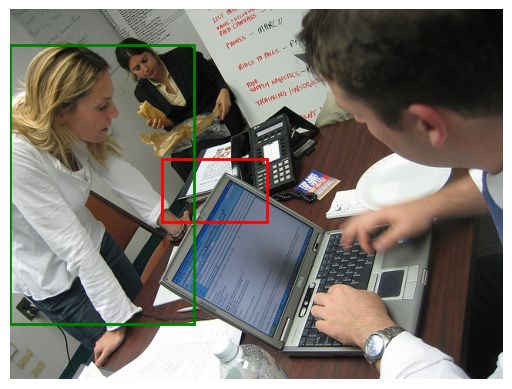

In [51]:
## plot the points
import matplotlib.pyplot as plt
import numpy as np
import cv2

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
## draw the bounding box of the predicted points
## by first getting the difference between the min and max x and y coordinates
x_min, y_min = min([point[0] for point in predicted]), min([point[1] for point in predicted])
x_max, y_max = max([point[0] for point in predicted]), max([point[1] for point in predicted])

## draw the rectangle
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

## draw the bounding box of the answer points
x_min, y_min = min([point[0] for point in answer]), min([point[1] for point in answer])
x_max, y_max = max([point[0] for point in answer]), max([point[1] for point in answer])
## draw the rectangle
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='g', facecolor='none')
plt.gca().add_patch(rect)

plt.show()


In [ ]:
len(inputs.input_ids[0])

In [ ]:
processor.tokenizer.encode("<seg000>")